# Amazon Food Reviews

Data Source:https://www.kaggle.com/snap/amazon-fine-food-reviews

This dataset consists of reviews of fine foods from Amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

![alt text](http://nycdatascience.com/blog/wp-content/uploads/2016/04/NewCover.png)

#### Data includes:
- Reviews from Oct 1999 - Oct 2012
- 568,454 reviews
- 256,059 users
- 74,258 products
- 260 users with > 50 reviews

#### Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

![alt text](http://nycdatascience.com/blog/wp-content/uploads/2016/04/AmazonReview.png)

In [3]:
# !pip install --upgrade pip
# !pip install qtconsole ipywidgets widgetsnbextension
# !pip install seaborn
# !pip install nltk
# import nltk
# nltk.download("stopwords")
# !pip install gensim


### Objective:- Review Polarity
Given a review, determine the review is positive or neagative

#### 1.Naive Way
Naive way to do this will be the to say Score with 1 & 2 -> Negative and 4 & 5 -> positive
and review with score 3 is ignored and we consider it as neutral

#### 2. Using text review to decide the polarity
Take the summary and text of review and analyze it using NLP whether the customer feedback/review is positive or negative


In [2]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as sql
import seaborn as sns
from time import time
import gensim


%matplotlib inline 
# sets the backend of matplotlib to the 'inline' backend:
#With this backend, the output of plotting commands is displayed inline within frontends like the Jupyter notebook,
#directly below the code cell that produced it. The resulting plots will then also be stored in the notebook document.

In [3]:
import pickle
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"))
def openfromfile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

In [4]:
# !wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/66.0.3359.139 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-US,en;q=0.9" "https://storage.googleapis.com/kaggle-datasets/18/2157/database.sqlite.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1526375292&Signature=G95OD7LgGsnAoencBUsNHa3R2iIGiXOhdITLbhQVxqZ9IGS3JA9ETgbJRa3tHTguzL0ignoIz2sjQUxyY2YbcD98XR8immdcAmrFlQVA6Jm%2BBju%2BpDGjF05FpW0wGeMq6utKq2Qy8eMtm3NW%2FA%2F7m557B%2Bi3kGcBP4uaEzMk6F%2BpGaZnxcroDAcjpSj9VzU03INKPwpkbxtM%2FrWCaX748Bpgx9uKqwfrRakGR%2BRCpnMHcUukj%2FhaKKRi9QoQaTNpdRjmVB%2FqewKwDXTN8sr701yMkmqItQXBJI9Y312GqSP3Vd%2B3oleta5HZ2L9xlBFyUcLoyUEItOxI4pTjukwu1A%3D%3D" -O "database.sqlite.zip" -c

## First Let's do the EDA

### Loading the data

In [5]:
#Using sqlite3 to retrieve data from sqlite file

con = sql.connect("database.sqlite")#Connection object that represents the database

#Using pandas functions to query from sql table
df = pd.read_sql_query("""
SELECT * FROM Reviews 
""",con)

#Reviews is the name of the table given
#Taking only the data where score != 3 as score 3 will be neutral and it won't help us much
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


In [7]:
df.shape
df['Score'].size

568454

In [8]:
# sns.FacetGrid(df).\
# map(plt.hist,bins=df['Score'])
# # plt.plot(df['Score'].value_counts())
# plt.show()

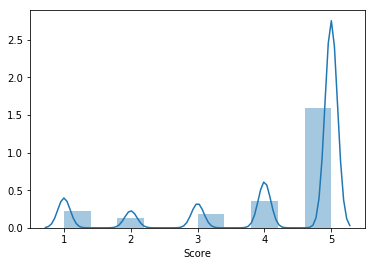

In [9]:
sns.distplot(df['Score'],bins=10)
plt.show()

In [10]:
df['Score'].value_counts()

5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64

In [11]:
#Using pandas functions to query from sql table
df = pd.read_sql_query("""
SELECT * FROM Reviews 
WHERE Score != 3
""",con)

## 1. Naive Way

Score as positive or negative

In [12]:
def polarity(x):
    if x < 3:
        return 'Negative'
    else:
        return 'Positive'
df["Score"] = df["Score"].map(polarity) #Map all the scores as the function polarity i.e. positive or negative
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


 Using Score column now we can say either a Review is positive or negative

## 2.Using Text data and Natural Language Processing (NLP)

Firstly we need to perform some data cleaning and then text preprocessing and convert the texts as vectors so that we can train some model on those vectors and predict polarity of the review

### 1.Data Cleaning

#### (i) Data Deduplication

In [13]:
df.duplicated(subset={"UserId","ProfileName","Time","Text"}).value_counts()

False    364173
True     161641
dtype: int64

There exist alot of duplicates wherein the different products is <b>reviewed by same user at the same time</b> <br>
The product ID may be different but the product is similar with different variant

In [14]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display



,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


Geeta gave the review at the same time for multiple product which is not possible ethically, the product were same but different flavours hence counted as multiple products

In [15]:
#Deleting all the duplicates having the same userID, Profile, NameTime and Text all in the same column.
df1 =  df.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep="first")

In [16]:
size_diff = df1['Id'].size/df['Id'].size
print("%.1f %% reduction in data after deleting duplicates"%((1-size_diff)*100))
print("Size of data",df1['Id'].size," rows ")

30.7 % reduction in data after deleting duplicates
Size of data 364173  rows 


#### (ii) Helpfullness Numerator Greater than Helpfullness Denominator

In [17]:
df2 = df1[df1.HelpfulnessNumerator <= df1.HelpfulnessDenominator]
print("Size of data",df2['Id'].size," rows ")

Size of data 364171  rows 


### Text Preprocessing

#### [1] HTML Tag Removal

In [18]:
import re #Regex (Regualar Expr Operations)
#string = r"sdfsdfd" :- r is for raw string as Regex often uses \ backslashes(\w), so they are often raw strings(r’\d’)

########Function to remove html tags from data
def striphtml(data):
    p = re.compile('<.*?>')#Find this kind of pattern
#     print(p.findall(data))#List of strings which follow the regex pattern
    return p.sub('',data) #Substitute nothing at the place of strings which matched the patterns

striphtml('<a href="foo.com" class="bar">I Want This <b>text!</b></a><>')


'I Want This text!'

#### [2] Punctuations Removal

In [19]:
########Function to remove All the punctuations from the text
def strippunc(data):
    p = re.compile(r'[?|!|\'|"|#|.|,|)|(|\|/|~|%|*]')
    return p.sub('',data)
strippunc("fsd*?~,,,( sdfsdfdsvv)#")

'fsd sdfsdfdsvv'

#### [3] Stopwords
Stop words usually refers to the most common words in a language are generally filtered out before or after processing of natural language data. Sometimes it is avoided to remove the stop words to support phrase search.

In [20]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = stopwords.words('english') #All the stopwords in English language
#excluding some useful words from stop words list as we doing sentiment analysis
excluding = ['against','not','don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
             'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 
             'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't",'shouldn', "shouldn't", 'wasn',
             "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
stop = [words for words in stop if words not in excluding]
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's',

#### [4] Stemming
Porter Stemmer: Most commonly used stemmer without a doubt, also one of the most gentle stemmers. Though it is also the most computationally intensive of the algorithms. It is also the oldest stemming algorithm by a large margin.

SnowBall Stemmer(Porter2): Nearly universally regarded as an improvement over porter, and for good reason. Porter himself in fact admits that it is better than his original algorithm. Slightly faster computation time than Porter, with a fairly large community around it.

In [21]:
from nltk.stem import SnowballStemmer
snow = SnowballStemmer('english') #initialising the snowball stemmer
print("Stem/Root words of the some of the words using SnowBall Stemmer:")
print(snow.stem('tasty'))
print(snow.stem('tasteful'))
print(snow.stem('tastiest'))
print(snow.stem('delicious'))
print(snow.stem('amazing'))
print(snow.stem('amaze'))
print(snow.stem('initialize'))
print(snow.stem('fabulous'))
print(snow.stem('Honda City'))
print(snow.stem('unpleasant'))

Stem/Root words of the some of the words using SnowBall Stemmer:
tasti
tast
tastiest
delici
amaz
amaz
initi
fabul
honda c
unpleas


![alt text](https://image.slidesharecdn.com/l02words-150814131138-lva1-app6892/95/natural-language-processing-l02-words-26-638.jpg?cb=1439558153)

### Preprocessing output for one review

In [22]:
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in df2['Text'][2:3].values: #Running only for 2nd review
    filtered_sentence=[]
    print(sent) #Each review
    sent=striphtml(sent)# remove HTMl tags
    sent=strippunc(sent)# remove Punctuation Symbols
    print(sent.split())
    for w in sent.split():
        print("================================>",w)
        if((w.isalpha()) and (len(w)>2)):#If it is a numerical value or character of lenght less than 2    
            if(w.lower() not in stop):# If it is a stopword
                s=(snow.stem(w.lower())).encode('utf8') #Stemming the word using SnowBall Stemmer
                print("Selected: Stem Word->",s)
                filtered_sentence.append(s)
            else:
                print("Eliminated as it is a stopword")
                continue
        else:
            print("Eliminated as it is a numerical value or character of lenght less than 2")
            continue 
#     print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    final_string.append(str1)
    print("***********************************************************************")
    print("Finally selected words from the review:\n",final_string)
    


This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch.
['This', 'is', 'a', 'confection', 'that', 'has', 'been', 'around', 'a', 'few', 'centuries', 'It', 'is', 'a', 'light', 'pillowy', 'citrus', 'gelatin', 'with', 'nuts', '-', 'in', 'this', 'case', 'Filberts', 'And', 'it', 'is', 'cut', 'into', 'tiny', 'squares', 'and', 'then', 'liberally', 'coated', 'with', 'powdered', 'sugar', 'And', 'it', 'is', 'a', 'tiny', 'mouthful', 'of', 'heaven', 'Not', 'too', 'chewy', 'and', 'very', 'flavorful', 'I', 'highly', 'recommend', 'this', 'yummy', 'treat', 

## Preprocessing on all the reviews

In [23]:
%%time
# Code takes a while to run as it needs to run on around 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
t0=time()
for sent in df2['Text'].values:
    filtered_sentence=[]
#     print(sent) #Each review
    sent=striphtml(sent)# remove HTMl tags
    sent=strippunc(sent)# remove Punctuation Symbols
#     print(sent.split())
    for w in sent.split():
#         print("================================>",w)
        if((w.isalpha()) and (len(w)>2)):#If it is a numerical value or character of lenght less than 2    
            if(w.lower() not in stop):# If it is a stopword
                s=(snow.stem(w.lower())).encode('utf8') #Stemming the word using SnowBall Stemmer
                                        #encoding as byte-string/utf-8
#                 print("Selected: Stem Word->",s)
                filtered_sentence.append(s)
                if (df2['Score'].values)[i] == 'Positive': 
                    all_positive_words.append(s) #list of all words used to describe positive reviews
                if(df2['Score'].values)[i] == 'Negative':
                    all_negative_words.append(s) #list of all words used to describe negative reviews reviews
            else:
#                 print("Eliminated as it is a stopword")
                continue
        else:
#             print("Eliminated as it is a numerical value or character of lenght less than 2")
            continue 
#     print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
            #encoding as byte-string/utf-8
    
    final_string.append(str1)
#     print("***********************************************************************")
#     print("Finally selected words from the review:\n",final_string)
    i+=1
print("Preprocessing completed in ",time()-t0)

Preprocessing completed in  561.2557210922241


The above code uses string as byte-string / utf-8(uses 1 byte), Python defaut stores string as Unicode / (utf16/utf32) {depends on how python was compiled}-(uses 2/4 byte) as our data is large 1 byte difference can save a lot of memory. Hence encoding the data as byte-string  
For more info: https://stackoverflow.com/questions/10060411/byte-string-vs-unicode-string-python

### Postive and Negative words in reviews

In [24]:
from collections import Counter
print("No. of positive words:",len(all_positive_words))
print("No. of negative words:",len(all_negative_words))
# print("Sample postive words",all_positive_words[:9])
# print("Sample negative words",all_negative_words[:9])
positive = Counter(all_positive_words)
print("\nMost Common postive words",positive.most_common(10))
negative = Counter(all_negative_words)
print("\nMost Common negative words",negative.most_common(10))

No. of positive words: 11678044
No. of negative words: 2393854

Most Common postive words [(b'not', 145019), (b'like', 138335), (b'tast', 126024), (b'good', 109838), (b'love', 106551), (b'flavor', 106408), (b'use', 102872), (b'great', 101125), (b'one', 94396), (b'product', 88466)]

Most Common negative words [(b'not', 53634), (b'tast', 33828), (b'like', 32059), (b'product', 27411), (b'one', 20176), (b'flavor', 18898), (b'would', 17858), (b'tri', 17515), (b'use', 15148), (b'good', 14616)]


* "tast" , "like" , "flavor", "good" and "one" are some of the most common words in both negative and positve reviews
* "good" and "great" are some of the most common words in positive reviews
* "would" and "coffe" are some of the most common words in negative reviews 
* tasty, good, etc are some of the words common in both <b>because there may be a not before it like "not tasty" , "not good"</b>

### Storing our preprocessed data in DB

In [25]:
#Adding a column of CleanedText which displays the data after pre-processing of the review 
df2['CleanedText']=final_string
df2.head(3)

/opt/conda/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,b'bought sever vital can dog food product foun...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,b'product arriv label jumbo salt peanutsth pea...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,b'confect around centuri light pillowi citrus ...


In [26]:
### Storing dataframe in sqlite3
import sqlite3

con = sqlite3.connect('final.sqlite')
con.text_factory = str #To store the string as byte strings only
df2.to_sql('Reviews', con,if_exists='replace')


In [27]:
#Using sqlite3 to retrieve data from sqlite file

con = sql.connect("final.sqlite")#Loading Cleaned/ Preprocesed text that we did in Text Preprocessing

#Using pandas functions to query from sql table
df2 = pd.read_sql_query("""
SELECT * FROM Reviews 
""",con)

![alt text](https://ticary.com/assets/img/NLP.png)

# Some Key NLP Terms:

## Natural Language Processing (NLP) 
A Computer Science field connected to Artificial Intelligence and Computational Linguistics which focuses on interactions between computers and human language and a machine’s ability to understand, or mimic the understanding of human language. Examples of NLP applications include Siri and Google Now.

## Information Extraction 
The process of automatically extracting structured information from unstructured and/or semi-structured sources, such as text documents or web pages for example.

## Sentiment Analysis 
The use of Natural Language Processing techniques to extract subjective information from a piece of text. i.e. whether an author is being subjective or objective or even positive or negative. (can also be referred to as Opinion Mining). As in this case we doing sentiment analysis of reviews of users from Amazon.

## Data Corpus or Corpora 
A usually large collection of documents that can be used to infer and validate linguistic rules, as well as to do statistical analysis and hypothesis testing.eg. The Amazon Fine Food Review dataset is a corpus.

## Document
A "document" is a distinct text, you could treat an individual paragraph or even sentence as a "document".<br>
In our case our each review is a document


## Bag of Words (BoW)

A commonly used model in methods of Text Classification. As part of the BOW model, a piece of text (sentence or a document) is represented as a bag or multiset of words, disregarding grammar and even word order and the frequency or occurrence of each word is used as a feature for training a classifier.<br>
OR <br>
Simply,Converting a collection of text documents to a matrix of token counts

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

In [29]:
%%time
uni_gram = CountVectorizer() #in scikit-learn
uni_gram_vectors = uni_gram.fit_transform(df2['CleanedText'].values)

CPU times: user 17.9 s, sys: 120 ms, total: 18.1 s
Wall time: 18.1 s


In [30]:
#Saving the variable to access later without recomputing
savetofile(uni_gram_vectors,"uni_gram")

In [31]:
#Loading the variable from file
uni_gram_vectors = openfromfile("uni_gram")

In [ ]:
uni_gram_vectors.shape#209129

In [31]:
uni_gram_vectors.shape[1]

209129

In [11]:
uni_gram_vectors[0]

<1x209129 sparse matrix of type '<class 'numpy.int64'>'
	with 20 stored elements in Compressed Sparse Row format>

In [12]:
type(uni_gram_vectors)

scipy.sparse.csr.csr_matrix

In [95]:
%%time
from sklearn.decomposition import TruncatedSVD

tsvd_uni = TruncatedSVD(n_components=1000)#No of components as total dimensions
tsvd_uni_vec = tsvd_uni.fit_transform(uni_gram_vectors)

CPU times: user 30min 43s, sys: 29.7 s, total: 31min 13s
Wall time: 9min


In [96]:
savetofile(tsvd_uni,"tsvd_uni")
savetofile(tsvd_uni_vec,"tsvd_uni_vec")

In [26]:
tsvd_uni = openfromfile("tsvd_uni")
tsvd_uni_vec = openfromfile("tsvd_uni_vec")

In [27]:
tsvd_uni.explained_variance_ratio_[:].sum()

0.82439113222951488

In [28]:
%%time
from sklearn.manifold import TSNE
from time import time
import random

n_samples = 20000
sample_cols = random.sample(range(1, tsvd_uni_vec.shape[0]), n_samples)
sample_features = tsvd_uni_vec[sample_cols]
# sample_features = df
sample_class = df2['Score'][sample_cols]
sample_class = sample_class[:,np.newaxis]
print(sample_features.shape,sample_class.shape)
model = TSNE(n_components=2,random_state=0,perplexity=30)
# print(sample_features,sample_class)

t0 = time()
embedded_data = model.fit_transform(sample_features)
print("TSNE done in %0.3fs." % (time() - t0)) 
# print(embedded_data.shape,sample_class.shape)
final_data = np.concatenate((embedded_data,sample_class),axis=1)
print(final_data.shape)
newdf = pd.DataFrame(data=final_data,columns=["Dim1","Dim2","Class"])

(20000, 1000) (20000, 1)
TSNE done in 1716.121s.
(20000, 3)
CPU times: user 27min 30s, sys: 1min 5s, total: 28min 36s
Wall time: 28min 36s


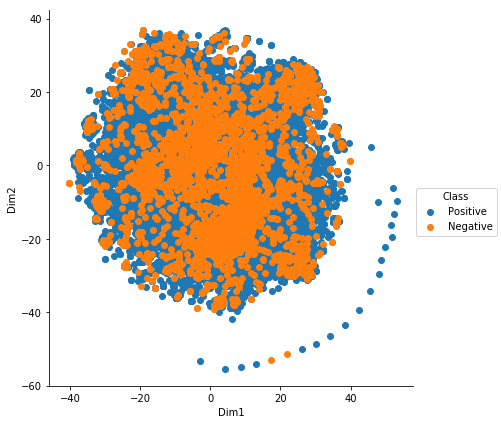

In [29]:
sns.FacetGrid(newdf,hue="Class",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.show()

(20000, 1000) (20000, 1)
TSNE done in 1952.465s.
(20000, 3)


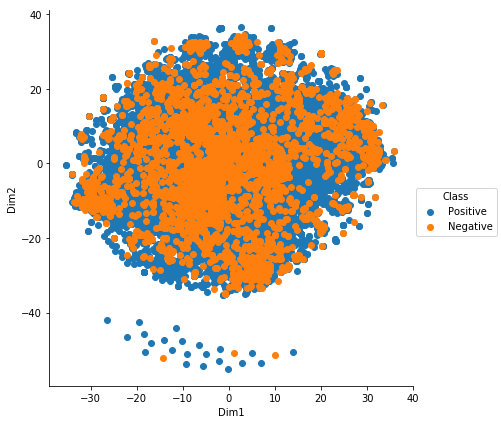

CPU times: user 31min 27s, sys: 1min 5s, total: 32min 33s
Wall time: 32min 33s


In [32]:
%%time
from sklearn.manifold import TSNE
from time import time
import random

n_samples = 20000
sample_cols = random.sample(range(1, tsvd_uni_vec.shape[0]), n_samples)
sample_features = tsvd_uni_vec[sample_cols]
# sample_features = df
sample_class = df2['Score'][sample_cols]
sample_class = sample_class[:,np.newaxis]
print(sample_features.shape,sample_class.shape)
model = TSNE(n_components=2,random_state=0,perplexity=40)
# print(sample_features,sample_class)

t0 = time()
embedded_data = model.fit_transform(sample_features)
print("TSNE done in %0.3fs." % (time() - t0)) 
# print(embedded_data.shape,sample_class.shape)
final_data = np.concatenate((embedded_data,sample_class),axis=1)
print(final_data.shape)
newdf = pd.DataFrame(data=final_data,columns=["Dim1","Dim2","Class"])

sns.FacetGrid(newdf,hue="Class",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.show()

(20000, 1000) (20000, 1)
TSNE done in 1718.082s.
(20000, 3)


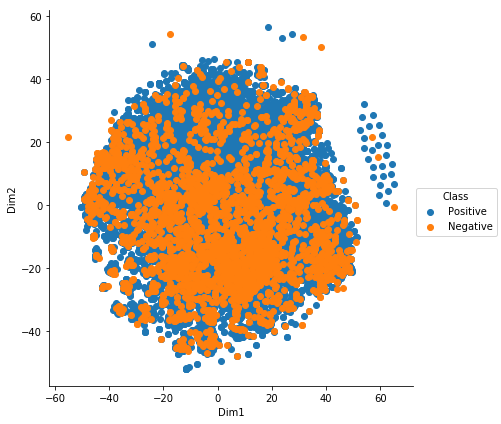

CPU times: user 27min 32s, sys: 1min 6s, total: 28min 38s
Wall time: 28min 38s


In [43]:
%%time
from sklearn.manifold import TSNE
from time import time
import random

n_samples = 20000
sample_cols = random.sample(range(1, tsvd_uni_vec.shape[0]), n_samples)
sample_features = tsvd_uni_vec[sample_cols]
# sample_features = df
sample_class = df2['Score'][sample_cols]
sample_class = sample_class[:,np.newaxis]
print(sample_features.shape,sample_class.shape)
model = TSNE(n_components=2,random_state=0,perplexity=20)
# print(sample_features,sample_class)

t0 = time()
embedded_data = model.fit_transform(sample_features)
print("TSNE done in %0.3fs." % (time() - t0)) 
# print(embedded_data.shape,sample_class.shape)
final_data = np.concatenate((embedded_data,sample_class),axis=1)
print(final_data.shape)
newdf = pd.DataFrame(data=final_data,columns=["Dim1","Dim2","Class"])

sns.FacetGrid(newdf,hue="Class",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.show()

### bi-gram

In [6]:
%%time
#taking one words and two consecutive words together
bi_gram = CountVectorizer(ngram_range=(1,2))
bi_gram_vectors = bi_gram.fit_transform(df2['CleanedText'].values)

In [7]:
#Saving the variable to access later without recomputing
savetofile(bi_gram_vectors,"bi_gram")

In [3]:
#Loading the variable from file
bi_gram_vectors = openfromfile("bi_gram")

In [49]:
bi_gram_vectors.shape

(364171, 3404647)

In [50]:
bi_gram_vectors[0]

<1x3404647 sparse matrix of type '<class 'numpy.int64'>'
	with 42 stored elements in Compressed Sparse Row format>

In [51]:
type(bi_gram_vectors)

scipy.sparse.csr.csr_matrix

In [54]:
print("bi-gram is %.2f times more than uni-gram"%((bi_gram_vectors.shape[1]/uni_gram_vectors.shape[1])))#Dividing boths columns

bi-gram is 16.28 times more than uni-gram


In [1]:
%%time
from sklearn.decomposition import TruncatedSVD
sample_points = df2.sample(50000)

bi_gram = CountVectorizer(ngram_range=(1,2))
bi_gram_vectors = bi_gram.fit_transform(sample_points['CleanedText'])
tsvd_bi = TruncatedSVD(n_components=2500)#No of components as total dimensions
tsvd_bi_vec = tsvd_bi.fit_transform(bi_gram_vectors)

In [2]:
savetofile(tsvd_bi,"tsvd_bi")
savetofile(tsvd_bi_vec,"tsvd_bi_vec")

In [ ]:
tsvd_bi = openfromfile("tsvd_bi")
tsvd_bi_vec = openfromfile("tsvd_bi_vec")

In [18]:
tsvd_bi.explained_variance_ratio_[:].sum()

0.54746095014673746

## tf-idf

TFIDF = TF x IDF<br>
<br>Term Frequency: This summarizes how often a given word appears within a document.<br>
Inverse Document Frequency: This downscales words that appear a lot across documents in the corpus.
<br><br>
In information retrieval, tf–idf or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. The tf-idf value increases proportionally to the number of times a word appears in the document and is offset by the frequency of the word in the corpus, which helps to adjust for the fact that some words appear more frequently in general. It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. Tf-idf is one of the most popular term-weighting schemes today; 83% of text-based recommender systems in digital libraries use tf-idf.

![alt text](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/01/11181616/image-4.png)

In [ ]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
t0 = time()
tfidf = TfidfVectorizer(ngram_range=(1,2)) #Using bi-grams
tfidf_vec = tfidf.fit_transform(df2['CleanedText'])
print("Total time taken:",time()-t0)

In [ ]:
#Saving the variable to access later without recomputing
savetofile(tfidf_vec,"tfidf")

In [66]:
#Loading the variable from file
tfidf_vec = openfromfile("tfidf")

In [67]:
tfidf_vec.shape

(364171, 3404647)

tf-idf came up with 2.9 million features for the data corpus

In [ ]:
print(tfidf_vec[2])

Returns all the features which is non-zero for a particular review from the sparse matrix

In [ ]:
features = tfidf.get_feature_names()
features[190000:190010]

Some of the feature of the tf-idf

In [ ]:
def top_tfidf_features(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ind = np.argsort(row)[::-1][:top_n]
    #Sorting and getting the indexes using argsort and reversing to get descending wise and taking the top n values
    top_feats = [(features[i], row[i]) for i in topn_ind]
    df = pd.DataFrame(top_feats,columns = ['feature', 'tfidf'])
    return df
top_tfidfs = top_tfidf_features(tfidf_vec[3000,:].toarray()[0],features,20)#top 20 tfidf features of 3000th review
top_tfidfs

Top 20 tfidf features of 3000th review in the data corpus

In [ ]:
%%time
from sklearn.decomposition import TruncatedSVD

tsvd_tfidf = TruncatedSVD(n_components=100)#No of components as total dimensions
tsvd_tfidf_vec = tsvd_tfidf.fit_transform(tfidf_vec)


In [ ]:
savetofile(tsvd_tfidf,"tsvd_tfidf")
savetofile(tsvd_tfidf_vec,"tsvd_tfidf_vec")

In [ ]:
tsvd_tfidf_vec = openfromfile("tsvd_tfidf_vec")
tsvd_tfidf = openfromfile("tsvd_tfidf")

In [ ]:
tsvd_tfidf.explained_variance_ratio_[:].sum()

## Gensim
Gensim is a robust open-source vector space modeling and topic modeling toolkit implemented in Python. It uses NumPy, SciPy and optionally Cython for performance. Gensim is specifically designed to handle large text collections, using data streaming and efficient incremental algorithms, which differentiates it from most other scientific software packages that only target batch and in-memory processing.

## Word2Vec
[Refer Docs] :https://radimrehurek.com/gensim/models/word2vec.html 

In [74]:
final_string = []
for sent in df2['CleanedText'].values:
    sent = str(sent)
    sentence=[]
#     print(sent)
    for word in sent.split():
#         print(word)
        sentence.append(word)
#         print(sentence)
    final_string.append(sentence)

In [78]:
%%time
# Train your own Word2Vec model using your own text corpus
import gensim

w2v_model=gensim.models.Word2Vec(final_string,min_count=5,size=50, workers=-1)
#min-count: Ignoring the words which occurs less than 5 times
#size:Creating vectors of size 50 for each word
#workers: Use these many worker threads to train the model (faster training with multicore machines)

CPU times: user 4.97 s, sys: 12 ms, total: 4.98 s
Wall time: 4.98 s


In [79]:
w2v_model.save('w2vmodel')#Persist/Saving the model to a file in the disk 

In [82]:
w2v_model = gensim.models.Word2Vec.load('w2vmodel') #Loading the model from file in the disk

In [83]:
w2v_vocub = w2v_model.wv.vocab
len(w2v_vocub)

34906

In [13]:
w2v_model.wv.most_similar('like')

[('milkwhen', 0.5297747254371643),
 ("lite'", 0.5197658538818359),
 ('shotth', 0.487257719039917),
 ('unaffect', 0.4854586720466614),
 ('present', 0.48249438405036926),
 ('nineti', 0.4789414405822754),
 ("wait'", 0.4766882658004761),
 ('plasticki', 0.4758199453353882),
 ('spackl', 0.47529834508895874),
 ('cozumel', 0.4741262197494507)]

In [26]:
w2v_model.wv.most_similar('tast')

[('occas', 0.5054408311843872),
 ('autom', 0.49969249963760376),
 ('rodeo', 0.4985140562057495),
 ("b'solid", 0.49587059020996094),
 ('goosebump', 0.476471871137619),
 ('round', 0.47308605909347534),
 ('feedbacki', 0.4717993140220642),
 ('noodlesth', 0.4693147540092468),
 ('nightim', 0.46523457765579224),
 ('junior', 0.4643288254737854)]

In [14]:
w2v_model.wv.most_similar('good')

[('thenif', 0.5075473189353943),
 ('insteadit', 0.4795317053794861),
 ('expensiveth', 0.47903549671173096),
 ('gimbal', 0.476731538772583),
 ('draini', 0.47530457377433777),
 ('martelli', 0.4727016091346741),
 ("stress'", 0.4722081422805786),
 ("b'formula", 0.4680376350879669),
 ("shirt'", 0.4675677418708801),
 ('onealso', 0.4674781560897827)]

## Avg Word2Vec
* One of the most naive but good ways to convert a sentence into a vector
* Convert all the words to vectors and then just take the avg of the vectors the resulting vector represent the sentence 

In [62]:
%%time
avg_vec = [] #List to store all the avg w2vec's 
for sent in final_string[0:1]:
    cnt = 0 #to count no of words in each reviews
    sent_vec = np.zeros(50) #Initializing with zeroes
    print("sent:",sent) 
    for word in sent:
        try:
            wvec = w2v_model.wv[word] #Vector of each using w2v model
            print("wvec:",wvec)
            sent_vec += wvec #Adding the vectors 
            cnt += 1
        except: 
            pass #When the word is not in the dictionary then do nothing 
    print("sent_vec:",sent_vec)    
    a_vec =sent_vec / cnt #Taking average of vectors sum of the particular review
    print("avg_vec:",a_vec)
    avg_vec.append(a_vec) #Storing the avg w2vec's for each review
    print("*******************************************************************")
   

sent: ["b'bought", 'sever', 'vital', 'can', 'dog', 'food', 'product', 'found', 'good', 'qualiti', 'product', 'look', 'like', 'stew', 'process', 'meat', 'smell', 'better', 'labrador', 'finicki', 'appreci', 'product', "better'"]
wvec: [ -4.75264713e-03  -2.68976251e-03   3.45981750e-03   8.61182716e-03
  -3.45326052e-03  -6.07945665e-04  -3.81294428e-03   7.70723587e-03
  -6.99552661e-03  -2.04596203e-03  -4.63803299e-03  -7.98908077e-05
  -5.44417766e-04  -6.50190702e-03   4.06994065e-03   3.06597492e-03
  -7.19741359e-03  -8.84887390e-03  -8.55807401e-03   5.74907893e-03
   6.90606283e-03   3.70534114e-03   4.26333630e-03  -9.67295747e-03
  -5.33873122e-03   2.21293815e-03   5.71956998e-03   4.67022089e-03
  -5.25551289e-03   7.90084433e-03  -8.64620041e-03   1.24186510e-03
   6.92145852e-03   7.15341698e-03   1.75182312e-03   2.55550840e-03
   6.01556059e-03   1.02293317e-03  -7.80893781e-04   7.74320262e-03
  -5.13905776e-04  -1.03073404e-03   3.13923252e-03   1.53249697e-04
   2.411

In [63]:
%%time
np.seterr(divide='ignore', invalid='ignore')
avg_vec = [] #List to store all the avg w2vec's 
for sent in final_string:
    cnt = 0 #to count no of words in each reviews
    sent_vec = np.zeros(50) #Initializing with zeroes
    for word in sent:
        try:
            wvec = w2v_model.wv[word] #Vector of each using w2v model
            sent_vec += wvec #Adding the vectors 
            cnt += 1
        except: 
            pass #When the word is not in the dictionary then do nothing 
    sent_vec /= cnt #Taking average of vectors sum of the particular review
    avg_vec.append(a_vec) #Storing the avg w2vec's for each review
    #print("*******************************************************************")
    # Average Word2Vec


CPU times: user 1min 26s, sys: 0 ns, total: 1min 26s
Wall time: 1min 26s


In [ ]:
#Saving the variable to access later without recomputing
savetofile(avg_vec,"avg_w2v_vec")

In [4]:
#Loading the variable from file
avg_vec = openfromfile("avg_w2v_vec")

In [40]:
avg_vec = np.array(avg_vec)
avg_vec.shape

(364171, 50)

In [33]:
from sklearn import preprocessing
avg_vec_norm = preprocessing.normalize(avg_vec)

In [21]:
%%time
from sklearn.manifold import TSNE
from time import time
import random

n_samples = 20000
sample_cols = random.sample(range(1, avg_vec.shape[0]), n_samples)
sample_features = avg_vec[sample_cols]
# sample_features = df
sample_class = df2['Score'][sample_cols]
sample_class = sample_class[:,np.newaxis]
print(sample_features.shape,sample_class.shape)
model = TSNE(n_components=2,random_state=0,perplexity=30)

embedded_data = model.fit_transform(sample_features)
# print(embedded_data.shape,sample_class.shape)
final_data = np.concatenate((embedded_data,sample_class),axis=1)
print(final_data.shape)
newdf = pd.DataFrame(data=final_data,columns=["Dim1","Dim2","Class"])


(20000, 50) (20000, 1)
TSNE done in 767.050s.
(20000, 3)
CPU times: user 11min 46s, sys: 1min, total: 12min 47s
Wall time: 12min 47s


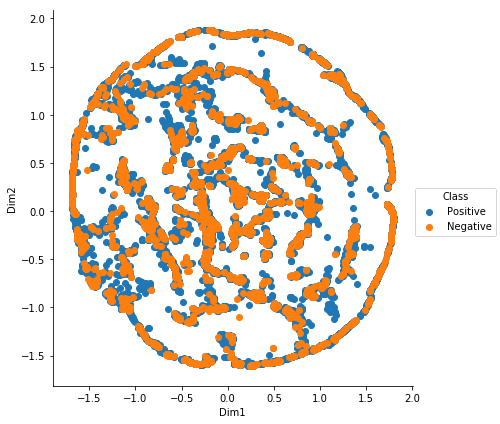

In [22]:
sns.FacetGrid(newdf,hue="Class",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.show()

In [30]:
%%time
from sklearn.manifold import TSNE
from time import time
import random

n_samples = 40000
sample_cols = random.sample(range(1, avg_vec.shape[0]), n_samples)
sample_features = avg_vec[sample_cols]
# sample_features = df
sample_class = df2['Score'][sample_cols]
sample_class = sample_class[:,np.newaxis]
print(sample_features.shape,sample_class.shape)
model = TSNE(n_components=2,random_state=0,perplexity=30)

embedded_data = model.fit_transform(sample_features)
# print(embedded_data.shape,sample_class.shape)
final_data = np.concatenate((embedded_data,sample_class),axis=1)
print(final_data.shape)
newdf = pd.DataFrame(data=final_data,columns=["Dim1","Dim2","Class"])


(40000, 50) (40000, 1)
(40000, 3)
CPU times: user 26min 9s, sys: 1min 50s, total: 27min 59s
Wall time: 28min


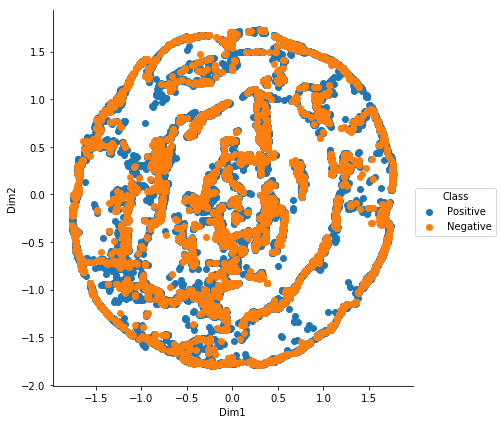

In [31]:
sns.FacetGrid(newdf,hue="Class",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.show()

In [38]:
%%time
from sklearn.manifold import TSNE
import random

n_samples = 20000
sample_cols = random.sample(range(1, avg_vec_norm.shape[0]), n_samples)
sample_features = avg_vec_norm[sample_cols]
# sample_features = df
sample_class = df2['Score'][sample_cols]
sample_class = sample_class[:,np.newaxis]
print(sample_features.shape,sample_class.shape)
model = TSNE(n_components=2,random_state=0,perplexity=20)

embedded_data = model.fit_transform(sample_features)
# print(embedded_data.shape,sample_class.shape)
final_data = np.concatenate((embedded_data,sample_class),axis=1)
print(final_data.shape)
newdf = pd.DataFrame(data=final_data,columns=["Dim1","Dim2","Class"])


(20000, 50) (20000, 1)
(20000, 3)
CPU times: user 8min 32s, sys: 47.3 s, total: 9min 19s
Wall time: 9min 19s


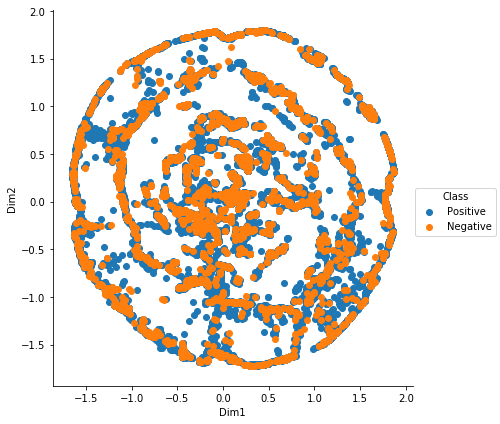

In [39]:
sns.FacetGrid(newdf,hue="Class",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.show()

In [41]:
%%time
from sklearn.manifold import TSNE
import random

n_samples = 20000
sample_cols = random.sample(range(1, avg_vec_norm.shape[0]), n_samples)
sample_features = avg_vec_norm[sample_cols]
# sample_features = df
sample_class = df2['Score'][sample_cols]
sample_class = sample_class[:,np.newaxis]
print(sample_features.shape,sample_class.shape)
model = TSNE(n_components=2,random_state=0,perplexity=40)

embedded_data = model.fit_transform(sample_features)
# print(embedded_data.shape,sample_class.shape)
final_data = np.concatenate((embedded_data,sample_class),axis=1)
print(final_data.shape)
newdf = pd.DataFrame(data=final_data,columns=["Dim1","Dim2","Class"])


(20000, 50) (20000, 1)
(20000, 3)
CPU times: user 15min 46s, sys: 1min 3s, total: 16min 50s
Wall time: 16min 50s


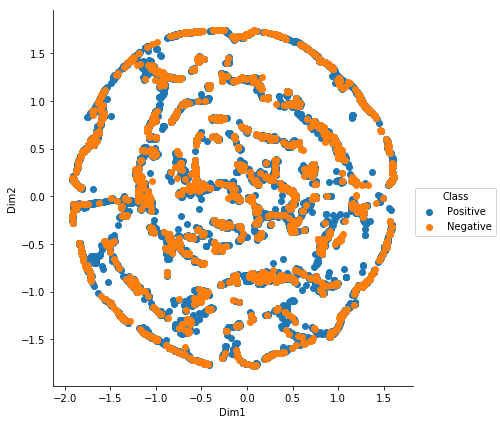

In [42]:
sns.FacetGrid(newdf,hue="Class",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.show()

## Tf-idf W2Vec
* Another way to covert sentence into vectors
* Take weighted sum of the vectors divided by the sum of all the tfidf's 
<br>i.e. (tfidf(word) x w2v(word))/sum(tfidf's)

In [ ]:
%%time
tfidf_w2vecs = []
review = 0
for sent in final_string:
    cnt = 0 
    weighted_sum  = 0
    sent_vec = np.zeros(50)
    for word in sent:
        try:
            wvec = w2v_model.wv[word]
#             print("w2vec:",wvec)
            tfidf = tfidf_vec[review,features.index(word)]
#             print(tfidf)
            sent_vec += (wvec * tfidf)
            weighted_sum += tfidf
        except:
            pass
    sent_vec /= weighted_sum
    tfidf_w2vecs.append(sent_vec)
    review += 1

In [ ]:
len(tfidf_w2vecs)

In [ ]:
len(tfidf_w2vecs[0])

In [ ]:
tfidf_w2vecs[5]

In [ ]:
savetofile(avg_vec,"avg_w2v_vec")
avg_vec = openfromfile("avg_w2v_vec")

## References:
(1) http://blog.aylien.com/10-common-nlp-terms-explained-for-the-text/<br>
(2) https://en.wikipedia.org/<br>
(3) https://buhrmann.github.io/tfidf-analysis.html<br>